## Imports and loading data

In [144]:
#import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import lightgbm as lgb
import catboost 
from datetime import datetime as dt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
#mounting google drive to load data from it
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/My Drive/Colab Notebooks/recruit

/content/gdrive/My Drive/Colab Notebooks/recruit


In [4]:
path=""

In [5]:
# Read csv files
air_reserve = pd.read_csv(path + 'air_reserve.csv')
air_reserve.name="air_reserve"
air_store_info = pd.read_csv(path + 'air_store_info.csv')
air_store_info.name="air_store_info"
air_visit_data = pd.read_csv(path + 'air_visit_data.csv')
air_visit_data.name="air_visit_data"
hpg_reserve = pd.read_csv(path + 'hpg_reserve.csv')
hpg_reserve.name="hpg_reserve"
hpg_store_info = pd.read_csv(path + 'hpg_store_info.csv')
hpg_store_info.name="hpg_store_info"
store_id_relation = pd.read_csv(path + 'store_id_relation.csv')
store_id_relation.name="store_relation_id"
date_info = pd.read_csv(path + 'date_info.csv')
date_info.name="date_info"
sample_sub = pd.read_csv(path + 'sample_submission.csv')

## EDA

###### Checking for Missing Data

In [ ]:
listofdf=[air_reserve,air_store_info,date_info,hpg_reserve,hpg_store_info,store_id_relation]
for df in listofdf:
    print(df.isnull().sum(), "\n")

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64 

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64 

calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64 

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64 

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64 

air_store_id    0
hpg_store_id    0
dtype: int64 



No missing data was found

###### Stats of each dataset

In [ ]:
for df in listofdf:
    print(df.name,"\n")
    print(df.describe(),"\n")

air_reserve 

       reserve_visitors
count      92378.000000
mean           4.481749
std            4.919669
min            1.000000
25%            2.000000
50%            3.000000
75%            5.000000
max          100.000000 

air_store_info 

         latitude   longitude
count  829.000000  829.000000
mean    35.647042  137.415311
std      2.084659    3.650971
min     33.211967  130.195555
25%     34.695124  135.341564
50%     35.658068  139.685474
75%     35.694003  139.751599
max     44.020632  144.273398 

date_info 

       holiday_flg
count   517.000000
mean      0.067698
std       0.251471
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000 

hpg_reserve 

       reserve_visitors
count      2.000320e+06
mean       5.073785e+00
std        5.416172e+00
min        1.000000e+00
25%        2.000000e+00
50%        3.000000e+00
75%        6.000000e+00
max        1.000000e+02 

hpg_store_info 

          latitude    longitude
count  4690.0

#### Visualization

###### *Reservation data*

In [60]:
airres=air_reserve.copy()
hpgres=hpg_reserve.copy()

In [61]:
#convert visit date and time to separate date and time columns 
airres['Dates'] = pd.to_datetime(airres['visit_datetime']).dt.date
airres['Time'] = pd.to_datetime(airres['visit_datetime']).dt.time

hpgres['Dates'] = pd.to_datetime(hpgres['visit_datetime']).dt.date
hpgres['Time'] = pd.to_datetime(hpgres['visit_datetime']).dt.time

In [62]:
#group the reservations by date to check the reservation trend
group_date_air=airres.groupby(['Dates']).sum()
group_date_hpg=hpgres.groupby(['Dates']).sum()

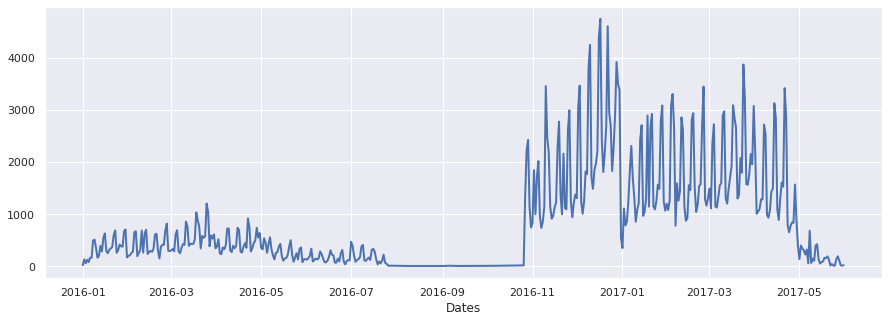

In [63]:
#plot reservation visitors vs date from airreserve
sns.set(rc={'figure.figsize':(15,5)})
group_date_air['reserve_visitors'].plot(linewidth=2);

In [ ]:
#There is missing data from July 2016 to November 2016 after which there is a huge spike of visitors. 
#New years time may have more number of people who go out for dining

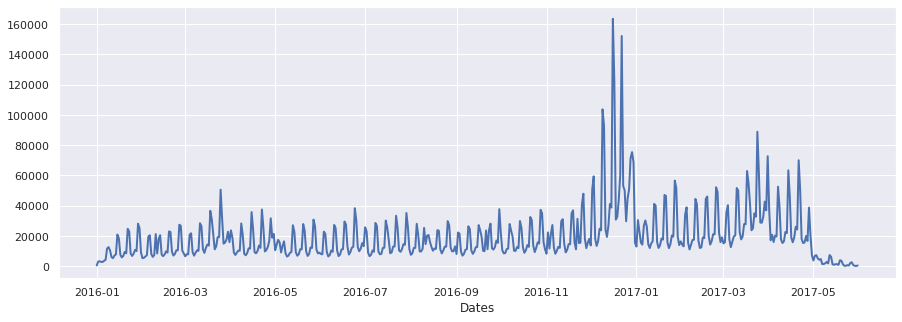

In [64]:
#plot reservation visitors vs date from hpg_reserve
sns.set(rc={'figure.figsize':(15,5)})
group_date_hpg['reserve_visitors'].plot(linewidth=2);

In [ ]:
#Here again there is spike in January which might suggest the New Years time is popular for Dining out

##### *Holiday info*

In [65]:
date=date_info.copy()

In [66]:
date['holiday_flg']=date['holiday_flg'].astype(int)
datehol=date.loc[date['holiday_flg']==1]

In [67]:
datehol.groupby('day_of_week').sum()

,holiday_flg
day_of_week,
Friday,5
Monday,9
Saturday,5
Sunday,4
Thursday,7
Tuesday,2
Wednesday,3


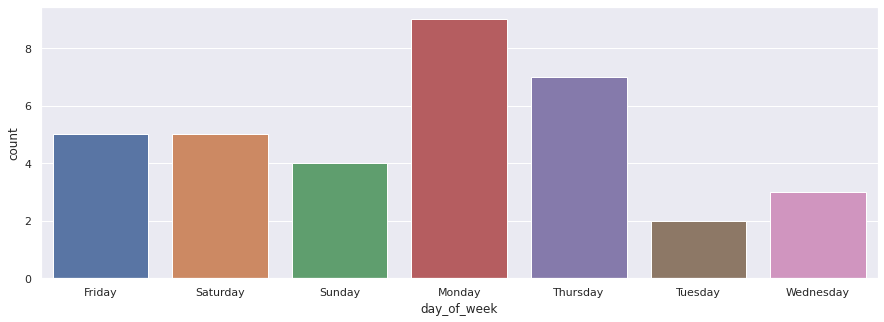

In [68]:
sns.countplot(data=datehol.groupby('day_of_week').mean(),x=datehol.day_of_week)
#count of holidays vs day of week
#monday has the hightest number of holidays

##### *Store id vs visitors*

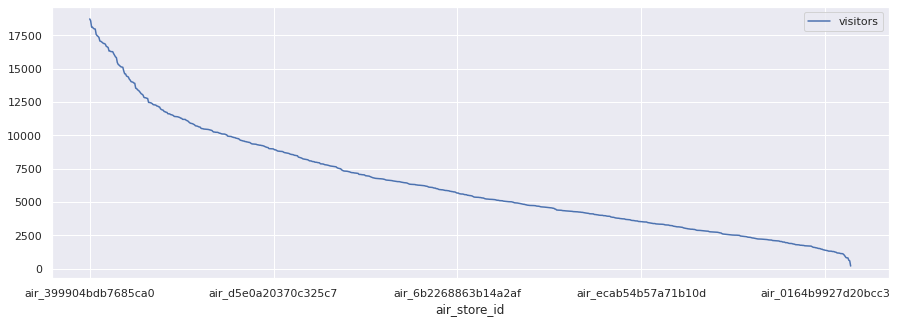

In [72]:
air_visit=air_visit_data.copy()
# air_Visit group by air_store_id
group_id_air_visit=air_visit.groupby(['air_store_id']).sum()
group_id_air_visit=group_id_air_visit.sort_values(by='visitors',ascending=False)
group_id_air_visit.plot()

#air store id vs total no of visitors

###### *Number of visitors and time*

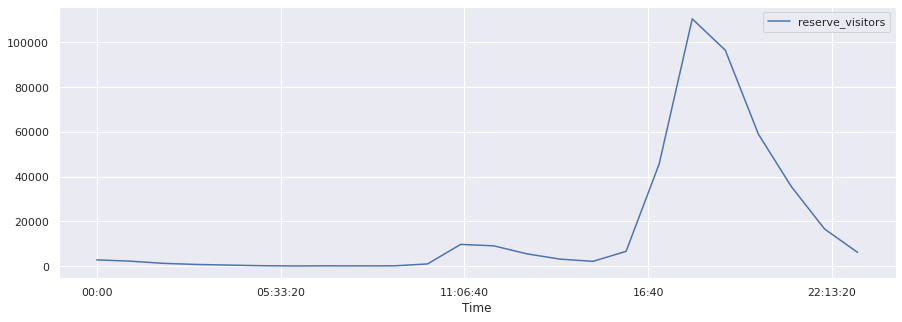

In [75]:
visitors_time=airres[['Time','reserve_visitors']]
group_visitors_time=visitors_time.groupby('Time').sum()
group_visitors_time.plot()

# time of day vs total number of visitors
# we can see the number of visitors peak at after 6pm 

##### *Area and Genre*

In [78]:
air_res_store=pd.merge(airres,air_store_info,on='air_store_id', how='inner')
air=pd.merge(air_res_store,air_visit,on='air_store_id',how='inner')

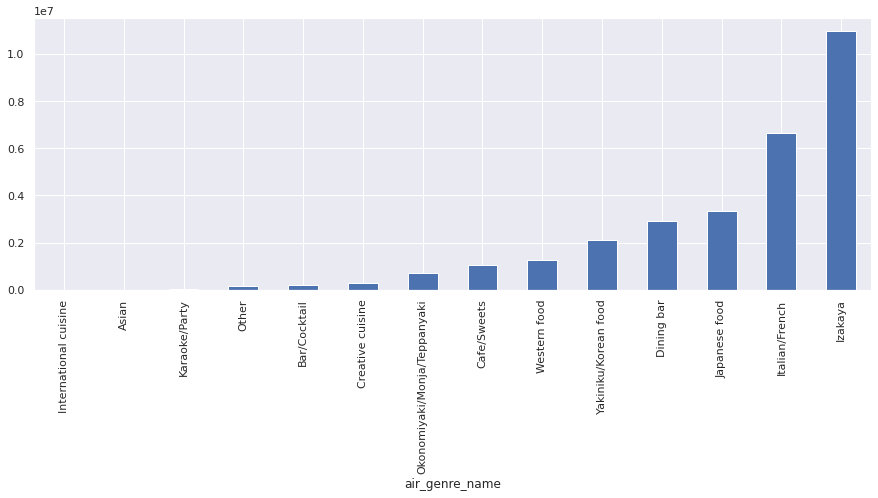

In [79]:
g_genre=air.groupby('air_genre_name')
df=g_genre['visitors'].count().sort_values().plot(kind='bar',align='center')
# Genre vs Number of visitors

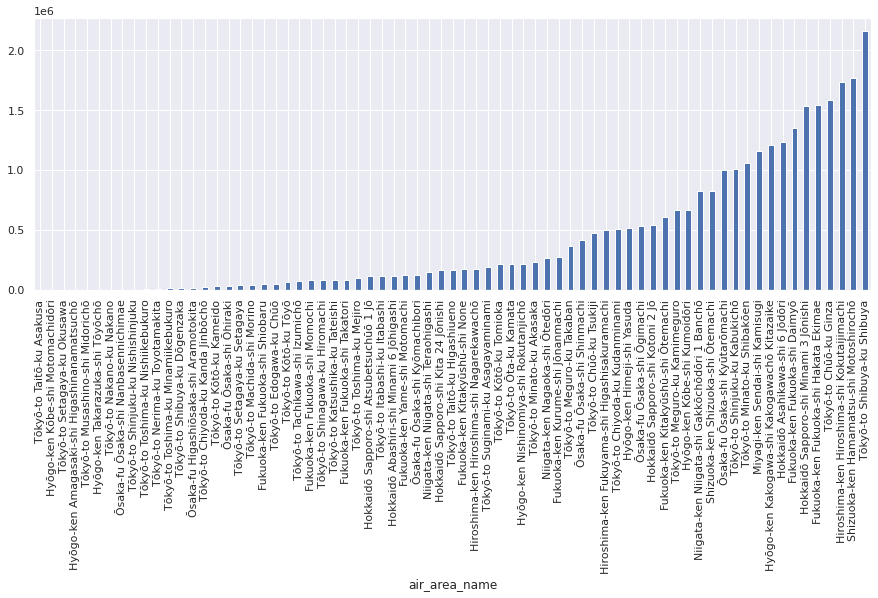

In [84]:
#visitors based on area name
g_genre=air.groupby('air_area_name')
df=g_genre['visitors'].count().sort_values().plot(kind='bar',align='center')
# area vs no of visitors

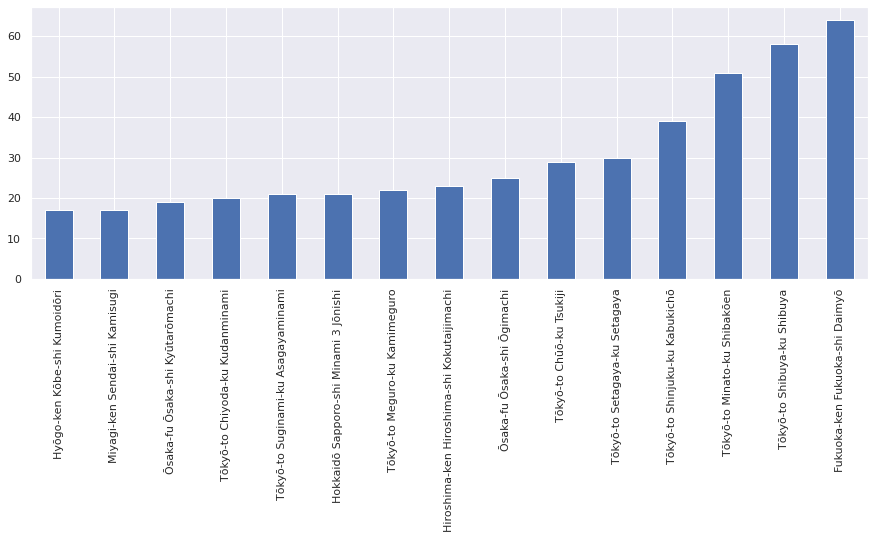

In [83]:
#top 15 areas with max restaurants
temp=air_store_info.air_area_name.value_counts()
temp[:15].sort_values().plot(kind='bar')

In [85]:
visits_dates=pd.merge(air_visit,date,left_on='visit_date', right_on='calendar_date',how='left')

##### *Trend of visitors if its a holiday*

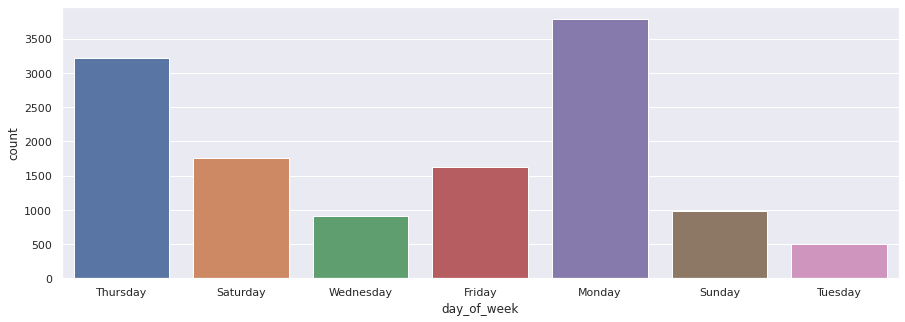

In [86]:
visits_dates_grp=visits_dates.loc[visits_dates['holiday_flg']==1]
sns.countplot(data=visits_dates_grp,x=visits_dates_grp.day_of_week)
#mondays are popular if its a holiday

##### *Trend of visitors if its not a holiday*

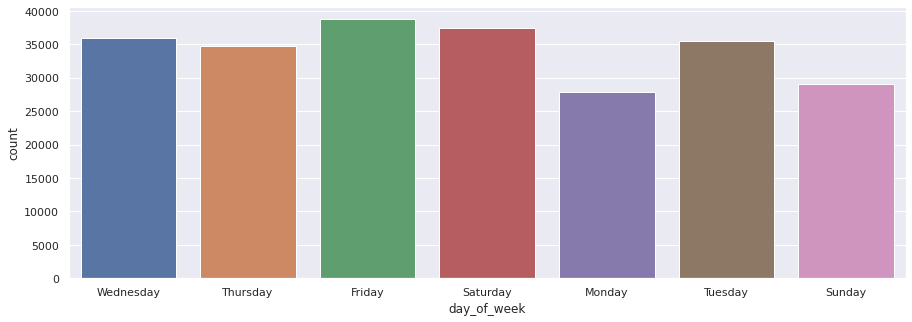

In [87]:
visits_dates_grp_normal=visits_dates.loc[visits_dates['holiday_flg']==0]
sns.countplot(data=visits_dates_grp_normal,x=visits_dates_grp_normal.day_of_week)
#friday is the most popular choice for a non holiday while monday is the least popular

In [94]:
visits_genre=pd.merge(air_visit,air_store_info,left_on='air_store_id', right_on='air_store_id',how='left')
visits_genre=visits_genre.drop(['latitude', 'longitude','air_area_name','air_store_id'], axis=1)

In [95]:
visits_genre['visit_date'] = pd.to_datetime(visits_genre.visit_date)
visits_genre['visit_date'] = visits_genre['visit_date'].dt.strftime('%Y-%m')
visits_genre_grp=visits_genre.groupby('air_genre_name').count()


In [96]:
visits_genre_grp_sum=visits_genre.groupby('air_genre_name').sum()
visits_genre_grp_sum['Count of each cuisine'] = visits_genre_grp['visitors']
visits_genre_grp_sum['Avg Visitors'] = visits_genre_grp_sum['visitors']/visits_genre_grp_sum['Count of each cuisine']
visits_genre_grp_sum.sort_values(by=['Avg Visitors'], ascending=False)

,visitors,Count of each cuisine,Avg Visitors
air_genre_name,,,
Asian,20730,535,38.747664
Karaoke/Party,15476,516,29.992248
International cuisine,9378,372,25.209677
Creative cuisine,91285,3868,23.600052
Izakaya,1432337,62052,23.082850
Okonomiyaki/Monja/Teppanyaki,83797,3706,22.611171
Cafe/Sweets,1192802,52764,22.606360
Italian/French,677737,30011,22.582953
Western food,109086,4897,22.276087


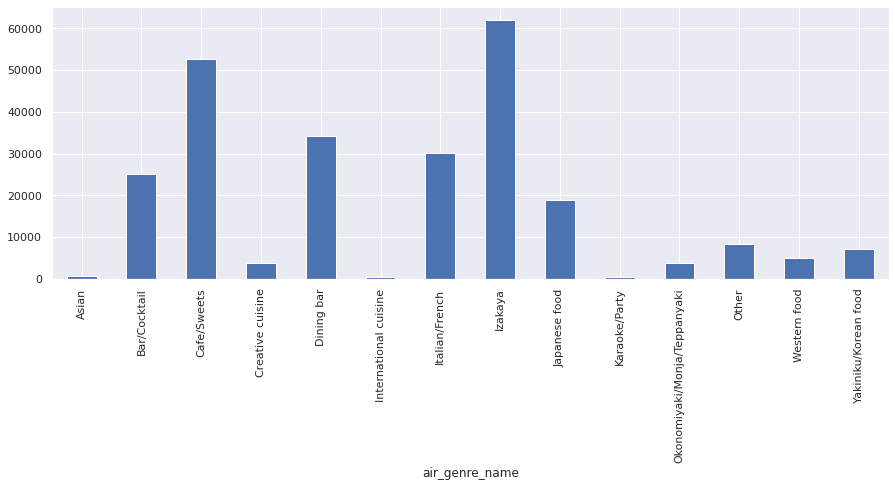

In [97]:
visits_genre.groupby(['air_genre_name']).size().plot(kind = "bar")

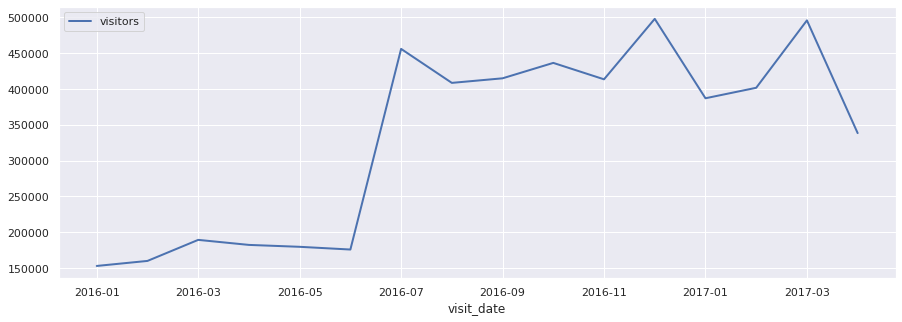

In [98]:
visits_genre.groupby(['visit_date']).sum().plot(linewidth=2)

## Feature Engineering

###### *Reservation Data*

In [100]:
# combine air and hpg Reserve databases 
hpg_air_reserve = store_id_relation.join(hpg_reserve.set_index('hpg_store_id'), on = 'hpg_store_id')
temp_air_reserve = air_reserve.copy()
#dropping hpg_store_id since its counter air_store_id is present
hpg_air_reserve = hpg_air_reserve.drop('hpg_store_id', axis = 1)
#concatenating the entire reserve data together 
reserve = pd.concat([temp_air_reserve, hpg_air_reserve])

In [101]:
# convert columns of "reserve" table into datetime format
reserve['visit_datetime'] =  pd.to_datetime(reserve['visit_datetime'])
reserve['reserve_datetime'] =  pd.to_datetime(reserve['reserve_datetime'])

# create column for visit date inside "reserve" table (since air_visit_data has the visit_date only and not the time, we'll need this columns while merging)
reserve['visit_date'] = reserve['visit_datetime'].apply(lambda x: str(x)[0:10])

# calculate the gap between visit time and reservation time inside "reserve" table
reserve['hour_gap'] = reserve['visit_datetime'].sub(reserve['reserve_datetime'])
reserve['hour_gap'] = reserve['hour_gap'].apply(lambda x: x/np.timedelta64(1,'h'))

In [102]:
# separate reservation into 5 categories based on gap length
# gaps are of length (0.5 day, 1 day, 1 day, 1 day, remaining time) 
reserve['reserve_-12_h'] = np.where(reserve['hour_gap'] <= 12,
                                    reserve['reserve_visitors'], 0)
reserve['reserve_12_37_h'] = np.where((reserve['hour_gap'] <= 37) & (reserve['hour_gap'] > 12),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_37_59_h'] = np.where((reserve['hour_gap'] <= 59) & (reserve['hour_gap'] > 37),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_59_85_h'] = np.where((reserve['hour_gap'] <= 85) & (reserve['hour_gap'] > 59),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_85+_h'] = np.where((reserve['hour_gap'] > 85),
                                     reserve['reserve_visitors'], 0)

In [103]:
# group by air_store_id and visit_date to enable joining with main table
group_list = ['air_store_id', 'visit_date', 'reserve_visitors', 'reserve_-12_h',
              'reserve_12_37_h', 'reserve_37_59_h', 'reserve_59_85_h', 'reserve_85+_h']

reserve = reserve[group_list].groupby(['air_store_id', 'visit_date'], as_index = False).sum()

###### Genre and Area

In [104]:
# total amount of restaurants of specific genres by area_name 
# group by air genre and area name
air_genres_in_area = air_store_info.copy()
air_genres_in_area = air_genres_in_area[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_genre_name', 'air_area_name'],
                                                                                              as_index = False).count()
air_genres_in_area = air_genres_in_area.rename(columns = {'air_store_id': 'genre_in_area'})

In [105]:
# merge df with air_genres_in_area to ge the total restaurants of same genre in an area, with respect to store id
def merge_genres_area(df):
    df = pd.merge(df, air_genres_in_area, how = 'left',left_on = ['air_genre_name', 'air_area_name'],right_on = ['air_genre_name', 'air_area_name'])
    return df

In [106]:
# total amount of restaurants in area 
# group by area name and count the no of restaurants in that area
air_area_total_ret = air_store_info.copy()
air_area_total_ret = air_area_total_ret[['air_store_id', 'air_area_name']].groupby(['air_area_name'], as_index = False).count()
air_area_total_ret = air_area_total_ret.rename(columns = {'air_store_id': 'total_rt_in_area'})

In [107]:
# merge df with air_area_total_ret to get the total number of restaurants in an area with respect to store id
def merge_total_rt_in_area(df):
  df = pd.merge(df, air_area_total_ret, how = 'left',left_on = ['air_area_name'],right_on = ['air_area_name'])
  return df;

###### *Holidays*

In [108]:
# additional features for weekends and holidays
date_info_mod = date_info.copy()
date_info_mod['holiday_eve'] = np.zeros(date_info_mod.shape[0])

In [109]:
# holiday eve feature created which marks whether the next day is a holiday or not
date_info_mod['holiday_eve'].iloc[:-1] = date_info_mod['holiday_flg'].copy().values[1:]
date_info_mod.head(4)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,calendar_date,day_of_week,holiday_flg,holiday_eve
0,2016-01-01,Friday,1,1.0
1,2016-01-02,Saturday,1,1.0
2,2016-01-03,Sunday,1,0.0
3,2016-01-04,Monday,0,0.0


In [110]:
# non_working_day feature indicates whether it is a working or non-working day. Includes holidays along with weekends
date_info_mod['non_working_day'] = np.where(date_info_mod['day_of_week'].isin(['Saturday', 'Sunday']) |date_info_mod['holiday_flg'] == 1, 1, 0)
date_info_mod.head(4)

,calendar_date,day_of_week,holiday_flg,holiday_eve,non_working_day
0,2016-01-01,Friday,1,1.0,1
1,2016-01-02,Saturday,1,1.0,1
2,2016-01-03,Sunday,1,0.0,1
3,2016-01-04,Monday,0,0.0,0


In [111]:
# drop redundant feature holiday_flag
date_info_mod = date_info_mod.drop('holiday_flg', axis = 1)

In [112]:
# joining air_visit_data with the date_info we created above
air_visit_wd = air_visit_data.join(date_info_mod.set_index('calendar_date'), on = 'visit_date')
air_visit_wd.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_eve,non_working_day
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0.0,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0.0,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0.0,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0.0,1
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0.0,0


In [113]:
# average visitors per restaurant by working and non-working days
# average visitors per restaurant
mean_of_visitors = air_visit_wd[['visitors','air_store_id','non_working_day']].copy().groupby(['air_store_id','non_working_day'],as_index = False).mean()
mean_of_visitors = mean_of_visitors.rename(columns = {'visitors': 'nwd_mean_visitors'})


# median visitors per restaurant
median_of_visitors = air_visit_wd[['visitors','air_store_id','non_working_day']].copy().groupby(['air_store_id','non_working_day'],as_index = False).median()
median_of_visitors = median_of_visitors.rename(columns = {'visitors': 'nwd_median_visitors'})


# max visitors per restaurant
max_visitors = air_visit_wd[['visitors','air_store_id','non_working_day']].copy().groupby(['air_store_id','non_working_day'],as_index = False).max()
max_visitors = max_visitors.rename(columns = {'visitors': 'nwd_max_visitors'})


In [114]:
# merge dataframe with the calculated data -> mean median and max visitors as per restaurant
def merge_calc_wd_data(data, calc_data):
    data = pd.merge(data, calc_data, how = 'left',left_on = ['air_store_id', 'non_working_day'],right_on = ['air_store_id', 'non_working_day'])
    return data

###### *Latitude and Longitude*

In [115]:
# calculate the sum of latitude and longitude which is then normalized
# calculate the difference between max latitude( or longitude )
def longitude_latitude_calc(data):
        
    data['longitude_latitude_sum'] = data['latitude'] + data['longitude']
    data['longitude_latitude_sum'] = data['longitude_latitude_sum'].apply(lambda x: np.log1p(x)) 
    
    data['diff_max_latitude'] = data['latitude'].max() - data['latitude']
    data['diff_max_longitude'] = data['longitude'].max() - data['longitude']
    
    return data

###### *Date Information*

In [116]:
# convert air store id + visit date into two separate columns
# divide date into separate features: date, month, day of week, week of year
def get_id_and_visit_date_details(X):    
    
    X['id'] = X['air_store_id'] + str('_') + X['visit_date']
    
    X['visit_date'] = pd.to_datetime(X['visit_date'],format= '%Y-%m-%d')
    X['visit_date_month'] =X.visit_date.dt.month
    X['visit_date_dayofw'] =X.visit_date.dt.dayofweek
    X['visit_date_year'] =X.visit_date.dt.year
    X['visit_date_dayofm'] =X.visit_date.dt.day
    X['weekofyear'] =X.visit_date.dt.weekofyear
    X.loc[X.weekofyear==53,'weekofyear'] =0 
    return X

###### *Merging features created till now*

In [117]:
# Merge all the feature engineered data
def merge_fe_data(data):
    # add month of visit
    data['month'] = data['visit_date'].apply(lambda x: float(str(x)[5:7]))

    # add weekday and holiday flag
    data = data.join(date_info_mod.set_index('calendar_date'), on = 'visit_date')
    # add genre and area name)
    data = data.join(air_store_info.set_index('air_store_id'), on = 'air_store_id')
    # add quantity of same genre in area
    data = merge_genres_area(data);
     # add total quatity of restaurants in area
    data = merge_total_rt_in_area(data);
   
    # add reservation information
    data = pd.merge(data, reserve, how = 'left', left_on = ['air_store_id', 'visit_date'],right_on = ['air_store_id', 'visit_date'])
    
    # add visitors number mean, median, max for each restaurant based on non-working day
    data = merge_calc_wd_data(data, mean_of_visitors)
    data = merge_calc_wd_data(data, median_of_visitors)
    data = merge_calc_wd_data(data, max_visitors)

    # add latitude and longitude sum and difference
    data = longitude_latitude_calc(data)
   
    # change NaN to 0
    data = data.fillna(0) 
    return data

In [118]:
# combine train/test data with additional information
air_train = air_visit_data.copy()
X = merge_fe_data(air_train)
X = get_id_and_visit_date_details(X)
X.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


,air_store_id,visit_date,visitors,month,day_of_week,holiday_eve,non_working_day,air_genre_name,air_area_name,latitude,longitude,genre_in_area,total_rt_in_area,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,nwd_mean_visitors,nwd_median_visitors,nwd_max_visitors,longitude_latitude_sum,diff_max_latitude,diff_max_longitude,id,visit_date_month,visit_date_dayofw,visit_date_year,visit_date_dayofm,weekofyear
0,air_ba937bf13d40fb24,2016-01-13,25,1.0,Wednesday,0.0,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-13,1,2,2016,13,2
1,air_ba937bf13d40fb24,2016-01-14,32,1.0,Thursday,0.0,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-14,1,3,2016,14,2
2,air_ba937bf13d40fb24,2016-01-15,29,1.0,Friday,0.0,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-15,1,4,2016,15,2
3,air_ba937bf13d40fb24,2016-01-16,22,1.0,Saturday,0.0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,51,0.0,0.0,0.0,0.0,0.0,0.0,23.211765,23.0,54,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-16,1,5,2016,16,2
4,air_ba937bf13d40fb24,2016-01-18,6,1.0,Monday,0.0,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-18,1,0,2016,18,3


In [119]:
# Merge the test data as well
air_test = sample_sub.copy()
air_test['air_store_id'] = air_test['id'].apply(lambda x: str(x)[:-11])
air_test['visit_date'] = air_test['id'].apply(lambda x: str(x)[-10:])
X_test = merge_fe_data(air_test)
X_test=get_id_and_visit_date_details(X_test)
X_test.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


,id,visitors,air_store_id,visit_date,month,day_of_week,holiday_eve,non_working_day,air_genre_name,air_area_name,latitude,longitude,genre_in_area,total_rt_in_area,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,nwd_mean_visitors,nwd_median_visitors,nwd_max_visitors,longitude_latitude_sum,diff_max_latitude,diff_max_longitude,visit_date_month,visit_date_dayofw,visit_date_year,visit_date_dayofm,weekofyear
0,air_e3020992d5fe5dfd_2017-04-06,0,air_e3020992d5fe5dfd,2017-04-06,4.0,Thursday,0.0,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,3,2017,6,14
1,air_e3020992d5fe5dfd_2017-04-07,0,air_e3020992d5fe5dfd,2017-04-07,4.0,Friday,0.0,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,4,2017,7,14
2,air_e3020992d5fe5dfd_2017-04-08,0,air_e3020992d5fe5dfd,2017-04-08,4.0,Saturday,0.0,1,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.849057,14.0,30,5.172995,8.349981,4.501537,4,5,2017,8,14
3,air_e3020992d5fe5dfd_2017-04-10,0,air_e3020992d5fe5dfd,2017-04-10,4.0,Monday,0.0,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,0,2017,10,15
4,air_e3020992d5fe5dfd_2017-04-11,0,air_e3020992d5fe5dfd,2017-04-11,4.0,Tuesday,0.0,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,1,2017,11,15


###### *Mean Median and Max Visitors based on different features*

In [120]:
# create copy of train and test set created till now
k = [i for i in X.columns if i in X_test.columns]
train = X.copy()
test = X_test.copy()

In [121]:
# normalize the columns that have large values
def normalize_data(data, col_name) :
  data[col_name] = data[col_name].apply(lambda x: np.log1p(x))
  return data

In [122]:
# Find the mean, median and max visitors of stores based on day of week, month

k1 = train[['visitors','air_store_id','visit_date_dayofw']].groupby(['air_store_id','visit_date_dayofw']).agg('mean').reset_index()
k1.columns = ['air_store_id','visit_date_dayofw','store_dayofw_mean_visitors']

k2 = train[['visitors','air_store_id','visit_date_dayofw']].groupby(['air_store_id','visit_date_dayofw']).agg('median').reset_index()
k2.columns = ['air_store_id','visit_date_dayofw','store_dayofw_median_visitors']

k3 = train[['visitors','air_store_id','visit_date_dayofw']].groupby(['air_store_id','visit_date_dayofw']).agg('max').reset_index()
k3.columns = ['air_store_id','visit_date_dayofw','store_dayofw_max_visitors']

k4 = train[['visitors','visit_date_month']].groupby(['visit_date_month']).agg('mean').reset_index()
k4.columns = ['visit_date_month','month_mean_visitors']

k5 = train[['visitors','visit_date_month']].groupby(['visit_date_month']).agg('median').reset_index()
k5.columns = ['visit_date_month','month_median_visitors']

# normalize max visitors
k6 = train[['visitors','visit_date_month']].groupby(['visit_date_month']).agg('max').reset_index()
k6.columns = ['visit_date_month','month_max_visitors']
k6 = normalize_data(k6, 'month_max_visitors')

k7 = train[['visitors','air_store_id']].groupby('air_store_id').agg('mean').reset_index()
k7.columns = ['air_store_id','store_mean_visitors']

k8 = train[['visitors','air_store_id']].groupby('air_store_id').agg('median').reset_index()
k8.columns = ['air_store_id','store_median_visitors']

k9 = train[['visitors','air_store_id']].groupby('air_store_id').agg('max').reset_index()
k9.columns = ['air_store_id','store_max_visitors']

k10 = train[['visitors','visit_date_dayofw']].groupby(['visit_date_dayofw']).agg('mean').reset_index()
k10.columns = ['visit_date_dayofw','dayofw_mean_visitors']

k11 = train[['visitors','visit_date_dayofw']].groupby(['visit_date_dayofw']).agg('median').reset_index()
k11.columns = ['visit_date_dayofw','dayofw_median_visitors']

# normalize max visitors
k12 = train[['visitors','visit_date_dayofw']].groupby(['visit_date_dayofw']).agg('max').reset_index()
k12.columns = ['visit_date_dayofw','dayofw_max_visitors']
k12 = normalize_data(k12, 'dayofw_max_visitors')

k13 = train[['visitors','air_store_id','visit_date_month']].groupby(['air_store_id','visit_date_month']).agg('mean').reset_index()
k13.columns = ['air_store_id','visit_date_month','store_month_mean_visitors']

k14 = train[['visitors','air_store_id','visit_date_month']].groupby(['air_store_id','visit_date_month']).agg('median').reset_index()
k14.columns = ['air_store_id','visit_date_month','store_month_median_visitors']

k15 = train[['visitors','air_store_id','visit_date_month']].groupby(['air_store_id','visit_date_month']).agg('max').reset_index()
k15.columns = ['air_store_id','visit_date_month','store_month_max_visitors']

In [123]:
# Merge all the newly created min max visitors with train and test set

train = X.copy()
test = X_test.copy()
train = train[k]
test = test[k]

train = train.merge(k1,on=['air_store_id','visit_date_dayofw'],how='left')
test = test.merge(k1,on= ['air_store_id','visit_date_dayofw'],how='left')

train = train.merge(k2,on=['air_store_id','visit_date_dayofw'],how='left')
test = test.merge(k2,on= ['air_store_id','visit_date_dayofw'],how='left')

train = train.merge(k3,on=['air_store_id','visit_date_dayofw'],how='left')
test = test.merge(k3,on= ['air_store_id','visit_date_dayofw'],how='left')

train = train.merge(k4,on=['visit_date_month'],how='left')
test = test.merge(k4,on= ['visit_date_month'],how='left')

train = train.merge(k5,on=['visit_date_month'],how='left')
test = test.merge(k5,on= ['visit_date_month'],how='left')

train = train.merge(k6,on=['visit_date_month'],how='left')
test = test.merge(k6,on= ['visit_date_month'],how='left')

train = train.merge(k7,on=['air_store_id'],how='left')
test = test.merge(k7,on= ['air_store_id'],how='left')

train = train.merge(k8,on=['air_store_id'],how='left')
test = test.merge(k8,on= ['air_store_id'],how='left')

train = train.merge(k9,on=['air_store_id'],how='left')
test = test.merge(k9,on= ['air_store_id'],how='left')

train = train.merge(k10,on=['visit_date_dayofw'],how='left')
test = test.merge(k10,on= ['visit_date_dayofw'],how='left')

train = train.merge(k11,on=['visit_date_dayofw'],how='left')
test = test.merge(k11,on= ['visit_date_dayofw'],how='left')

train = train.merge(k12,on=['visit_date_dayofw'],how='left')
test = test.merge(k12,on= ['visit_date_dayofw'],how='left')


train = train.merge(k13,on=['air_store_id','visit_date_month'],how='left')
test = test.merge(k13,on= ['air_store_id','visit_date_month'],how='left')

train = train.merge(k14,on=['air_store_id','visit_date_month'],how='left')
test = test.merge(k14,on= ['air_store_id','visit_date_month'],how='left')

train = train.merge(k15,on=['air_store_id','visit_date_month'],how='left')
test = test.merge(k15,on= ['air_store_id','visit_date_month'],how='left')

train.replace(np.nan,-1,inplace=True)
test.replace(np.nan,-1,inplace=True)

###### *Area and Genre - One hot encoding*

In [124]:
# split the area name and create new columns
# only first part of area will be used
def split_area(df):
  df[['area1','area2','area3','4','5']]=df.air_area_name.str.split(pat=' ',expand=True)
  df.drop(columns=['area3','4','5'],axis=1,inplace=True)
  return df

In [125]:
train=split_area(train)
test=split_area(test)

In [126]:
# one hot encoding of the area and genre columns for train set
dum=pd.get_dummies(train.area1)
dum2=pd.get_dummies(train.air_genre_name)
frames=[train,dum,dum2]
train=pd.concat(frames,axis=1)

# one hot encoding of the area and genre columns for train set
dum=pd.get_dummies(test.area1)
dum2=pd.get_dummies(test.air_genre_name)
frames=[test,dum,dum2]
test=pd.concat(frames,axis=1)

In [127]:
# drop columns not necessary for train set
k = ['air_store_id', u'visit_date', u'month', u'day_of_week', u'air_area_name', 'visit_date_year', u'latitude', u'longitude']
X = train.drop(k,axis=1)
X.head(5)

,visitors,holiday_eve,non_working_day,air_genre_name,genre_in_area,total_rt_in_area,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,nwd_mean_visitors,nwd_median_visitors,nwd_max_visitors,longitude_latitude_sum,diff_max_latitude,diff_max_longitude,id,visit_date_month,visit_date_dayofw,visit_date_dayofm,weekofyear,store_dayofw_mean_visitors,store_dayofw_median_visitors,store_dayofw_max_visitors,month_mean_visitors,month_median_visitors,month_max_visitors,store_mean_visitors,store_median_visitors,store_max_visitors,dayofw_mean_visitors,dayofw_median_visitors,dayofw_max_visitors,store_month_mean_visitors,store_month_median_visitors,store_month_max_visitors,area1,area2,Fukuoka-ken,Hiroshima-ken,Hokkaidō,Hyōgo-ken,Miyagi-ken,Niigata-ken,Shizuoka-ken,Tōkyō-to,Ōsaka-fu,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food
0,25,0.0,0,Dining bar,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-13,1,2,13,2,23.843750,25.0,57,19.976758,16,6.244167,22.782609,22.0,61,19.230121,16,6.777647,18.35,21.0,38,Tōkyō-to,Minato-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,32,0.0,0,Dining bar,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-14,1,3,14,2,20.292308,21.0,54,19.976758,16,6.244167,22.782609,22.0,61,18.922702,16,5.913503,18.35,21.0,38,Tōkyō-to,Minato-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,29,0.0,0,Dining bar,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-15,1,4,15,2,34.738462,35.0,61,19.976758,16,6.244167,22.782609,22.0,61,23.072737,19,5.786897,18.35,21.0,38,Tōkyō-to,Minato-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,22,0.0,1,Dining bar,8,51,0.0,0.0,0.0,0.0,0.0,0.0,23.211765,23.0,54,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-16,1,5,16,2,27.651515,27.0,53,19.976758,16,6.244167,22.782609,22.0,61,26.313688,22,6.016157,18.35,21.0,38,Tōkyō-to,Minato-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,6,0.0,0,Dining bar,8,51,0.0,0.0,0.0,0.0,0.0,0.0,22.663399,21.5,61,5.172809,8.362564,4.521799,air_ba937bf13d40fb24_2016-01-18,1,0,18,3,13.754386,12.0,34,19.976758,16,6.244167,22.782609,22.0,61,17.177009,14,5.855072,18.35,21.0,38,Tōkyō-to,Minato-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [128]:
# drop unnecessary columns for test
X_test = test.drop(k,axis=1)
X_test.head(5)

,visitors,holiday_eve,non_working_day,air_genre_name,genre_in_area,total_rt_in_area,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,nwd_mean_visitors,nwd_median_visitors,nwd_max_visitors,longitude_latitude_sum,diff_max_latitude,diff_max_longitude,id,visit_date_month,visit_date_dayofw,visit_date_dayofm,weekofyear,store_dayofw_mean_visitors,store_dayofw_median_visitors,store_dayofw_max_visitors,month_mean_visitors,month_median_visitors,month_max_visitors,store_mean_visitors,store_median_visitors,store_max_visitors,dayofw_mean_visitors,dayofw_median_visitors,dayofw_max_visitors,store_month_mean_visitors,store_month_median_visitors,store_month_max_visitors,area1,area2,Fukuoka-ken,Hiroshima-ken,Hokkaidō,Hyōgo-ken,Miyagi-ken,Niigata-ken,Shizuoka-ken,Tōkyō-to,Ōsaka-fu,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food
0,0,0.0,0,Italian/French,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,air_e3020992d5fe5dfd_2017-04-06,4,3,6,14,11.157895,8.5,27,21.816002,18,6.656727,12.464435,12.0,30,18.922702,16,5.913503,12.210526,13.0,21,Tōkyō-to,Chūō-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,Italian/French,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,air_e3020992d5fe5dfd_2017-04-07,4,4,7,14,16.023256,18.0,25,21.816002,18,6.656727,12.464435,12.0,30,23.072737,19,5.786897,12.210526,13.0,21,Tōkyō-to,Chūō-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0.0,1,Italian/French,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.849057,14.0,30,5.172995,8.349981,4.501537,air_e3020992d5fe5dfd_2017-04-08,4,5,8,14,13.625000,14.5,30,21.816002,18,6.656727,12.464435,12.0,30,26.313688,22,6.016157,12.210526,13.0,21,Tōkyō-to,Chūō-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,Italian/French,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,air_e3020992d5fe5dfd_2017-04-10,4,0,10,15,9.687500,9.0,22,21.816002,18,6.656727,12.464435,12.0,30,17.177009,14,5.855072,12.210526,13.0,21,Tōkyō-to,Chūō-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,Italian/French,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,air_e3020992d5fe5dfd_2017-04-11,4,1,11,15,11.025000,10.5,24,21.816002,18,6.656727,12.464435,12.0,30,17.672137,14,6.656727,12.210526,13.0,21,Tōkyō-to,Chūō-ku,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [129]:
# save newly created train and test set
X.to_csv('new_train.csv',index = False)
X_test.to_csv('new_test.csv',index = False)

## Training 

##### *Final train test set creation*

In [130]:
# Reading the train and  test data from new_train. and new_test.csv files respectively
ntrain = pd.read_csv(path + 'new_train.csv')
ntest = pd.read_csv(path +'new_test.csv')

In [131]:
# dropping id and visitors columns from test dataset and id column from train dataset
ntest_1=ntest.drop(['id','visitors'],axis=1)
ntrain_1=ntrain.drop(['id'],axis=1)

In [132]:
# selecting final features to train on
final_cols=['holiday_eve', 'non_working_day',
       'genre_in_area', 'total_rt_in_area', 'reserve_visitors',
       'reserve_-12_h', 'reserve_12_37_h', 'reserve_37_59_h',
       'reserve_59_85_h', 'reserve_85+_h', 'nwd_mean_visitors',
       'nwd_median_visitors', 'nwd_max_visitors', 'longitude_latitude_sum',
       'diff_max_latitude', 'diff_max_longitude', 'visit_date_month',
       'visit_date_dayofw', 'visit_date_dayofm', 'weekofyear',
       'store_dayofw_mean_visitors', 'store_dayofw_median_visitors',
       'store_dayofw_max_visitors',  'store_mean_visitors',
       'store_median_visitors', 'store_max_visitors', 'store_month_mean_visitors', 
       'store_month_median_visitors','store_month_max_visitors',
       'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Hyōgo-ken', 'Miyagi-ken',
       'Niigata-ken', 'Shizuoka-ken', 'Tōkyō-to', 'Ōsaka-fu', 'Asian',
       'Bar/Cocktail', 'Cafe/Sweets', 'Creative cuisine', 'Dining bar',
       'International cuisine', 'Italian/French', 'Izakaya', 'Japanese food',
       'Karaoke/Party', 'Okonomiyaki/Monja/Teppanyaki', 'Other',
       'Western food', 'Yakiniku/Korean food']

In [133]:
y = ntrain_1['visitors']
x = ntrain_1[final_cols]
test_x = ntest_1[final_cols]
test_x.head()

,holiday_eve,non_working_day,genre_in_area,total_rt_in_area,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,nwd_mean_visitors,nwd_median_visitors,nwd_max_visitors,longitude_latitude_sum,diff_max_latitude,diff_max_longitude,visit_date_month,visit_date_dayofw,visit_date_dayofm,weekofyear,store_dayofw_mean_visitors,store_dayofw_median_visitors,store_dayofw_max_visitors,store_mean_visitors,store_median_visitors,store_max_visitors,store_month_mean_visitors,store_month_median_visitors,store_month_max_visitors,Fukuoka-ken,Hiroshima-ken,Hokkaidō,Hyōgo-ken,Miyagi-ken,Niigata-ken,Shizuoka-ken,Tōkyō-to,Ōsaka-fu,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food
0,0.0,0,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,3,6,14,11.157895,8.5,27,12.464435,12.0,30,12.210526,13.0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.0,0,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,4,7,14,16.023256,18.0,25,12.464435,12.0,30,12.210526,13.0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.0,1,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.849057,14.0,30,5.172995,8.349981,4.501537,4,5,8,14,13.625000,14.5,30,12.464435,12.0,30,12.210526,13.0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.0,0,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,0,10,15,9.687500,9.0,22,12.464435,12.0,30,12.210526,13.0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.0,0,10,29,0.0,0.0,0.0,0.0,0.0,0.0,12.354839,12.0,27,5.172995,8.349981,4.501537,4,1,11,15,11.025000,10.5,24,12.464435,12.0,30,12.210526,13.0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


##### *Linear Regression*

In [134]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
# x = features used for training
# y = Target(ie- no of visitors)
regr.fit(x, y)

# Make predictions using the testing set
y_pred = regr.predict(test_x)

In [135]:
# create final_submissions dataframe out of y_pred array
final_submissions = ntest[['id','visitors']]
final_submissions['id'] = ntest[['id']]
final_submissions['visitors'] = pd.DataFrame({'visitors': y_pred})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [136]:
final_submissions = final_submissions.reindex(['id','visitors'],axis=1)

In [137]:
#Generate a submission csv file out of the predictions obtained from linear regression
final_submissions.to_csv('LinearRegression_FinalFeat.csv',index = False)

##### *Decision Tree Regressor - Hyper parameter Tuning with GridSearch and Cross Validation of 5*

In [138]:
# Hyper parameters for Decision Tree Regressor are max_depth and min_samples_split
# njobs = -1 which means that all threads are run parallelly

model = DecisionTreeRegressor()
gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=-1,
                  scoring='neg_mean_squared_log_error')

#Fit the model
gs.fit(x,y)
print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 10, 'min_samples_split': 50}
0.2746654141390682


In [139]:
# Make predictions using the Decision Tree Regressor
y_pred_tree = gs.predict(test_x)

In [140]:
# create final_submissions dataframe out of y_pred_tree array
final_submissions_tree = ntest[['id','visitors']]
final_submissions_tree['id'] = ntest[['id']]
final_submissions_tree['visitors'] = pd.DataFrame({'visitors': y_pred_tree})
final_submissions_tree = final_submissions_tree.reindex(['id','visitors'],axis=1)
final_submissions_tree.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,10.301092
1,air_e3020992d5fe5dfd_2017-04-07,16.822053
2,air_e3020992d5fe5dfd_2017-04-08,13.060459
3,air_e3020992d5fe5dfd_2017-04-10,10.301092
4,air_e3020992d5fe5dfd_2017-04-11,10.301092


In [141]:
#Generate a submission csv file out of the predictions obtained from Decision Tree Regressor
final_submissions_tree.to_csv('DecisionTree_FinalFeat.csv',index = False)

##### *K nearest neighbors*

In [145]:
model2 = KNeighborsRegressor(n_jobs=-1,n_neighbors=4)
print(model2)

#Fit Knn model
model2.fit(x, y)
preds2 = model2.predict(x)
print('RMSLE KNeighborsRegressor: ', mean_squared_log_error(y, preds2))
preds2 = model2.predict(test_x)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                    weights='uniform')
RMSLE KNeighborsRegressor:  0.1899994539937567


In [146]:
# create final_submissions dataframe out of preds2 array
final_submissions_knn_1 = ntest[['id','visitors']]
final_submissions_knn_1['id'] = ntest[['id']]
final_submissions_knn_1['visitors'] = pd.DataFrame({'visitors': preds2})
final_submissions_knn_1 = final_submissions_knn_1.reindex(['id','visitors'],axis=1)
final_submissions_knn_1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,8.25
1,air_e3020992d5fe5dfd_2017-04-07,17.75
2,air_e3020992d5fe5dfd_2017-04-08,14.75
3,air_e3020992d5fe5dfd_2017-04-10,9.00
4,air_e3020992d5fe5dfd_2017-04-11,9.00


In [147]:
# Knn with neighbors=3 
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor

model2 = KNeighborsRegressor(n_jobs=-1,n_neighbors=3)
print(model2)

model2.fit(x, y)
preds2 = model2.predict(x)
print('RMSLE KNeighborsRegressor: ', mean_squared_log_error(y, preds2))
preds2 = model2.predict(test_x)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                    weights='uniform')
RMSLE KNeighborsRegressor:  0.17018163164083275


In [149]:
# create final_submissions dataframe out of preds2 array
final_submissions_knn = ntest[['id','visitors']]
final_submissions_knn['id'] = ntest[['id']]
final_submissions_knn['visitors'] = pd.DataFrame({'visitors': preds2})
final_submissions_knn = final_submissions_knn.reindex(['id','visitors'],axis=1)
final_submissions_knn.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,7.666667
1,air_e3020992d5fe5dfd_2017-04-07,17.333333
2,air_e3020992d5fe5dfd_2017-04-08,15.000000
3,air_e3020992d5fe5dfd_2017-04-10,6.666667
4,air_e3020992d5fe5dfd_2017-04-11,8.000000


In [150]:
#Generate a submission csv file out of the predictions obtained from Knn
final_submissions_knn_1.to_csv('Knn_Neighbors.csv',index = False)

##### *XgBoost Model using train,test and split method to split train dataset into Training and Validation Datasets*

In [151]:
  
# Splitting 
train_X, test_valid_x, train_y, test_valid_y = train_test_split(x, y, test_size = 0.3, random_state = 123) 
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123) 
  
# Fitting the model 
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_valid_x) 
  
# RMSE Computation 
rmse = np.sqrt(mean_squared_log_error(test_valid_y, pred)) 
print("RMSE : % f" %(rmse)) 

[09:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.587321


In [152]:
y_pred_xgboost = xgb_r.predict(test_x)

In [153]:
final_submissions_xgboost = ntest[['id','visitors']]
final_submissions_xgboost['id'] = ntest[['id']]
final_submissions_xgboost['visitors'] = pd.DataFrame({'visitors': y_pred_xgboost})
final_submissions_xgboost = final_submissions_xgboost.reindex(['id','visitors'],axis=1)
final_submissions_xgboost.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,7.805145
1,air_e3020992d5fe5dfd_2017-04-07,10.205526
2,air_e3020992d5fe5dfd_2017-04-08,8.894953
3,air_e3020992d5fe5dfd_2017-04-10,6.540884
4,air_e3020992d5fe5dfd_2017-04-11,7.805145


In [154]:
final_submissions_xgboost.to_csv('XGBoost.csv',index = False)

##### *Light Gradient Boosting Model - with Train, test and split method*

In [159]:
import lightgbm
# Splitting 
train_X, test_valid_x, train_y, test_valid_y = train_test_split(x, y, test_size = 0.2, random_state = 150) 

# Create the LightGBM data containers

train_data = lightgbm.Dataset(train_X, label=train_y)
test_data = lightgbm.Dataset(test_valid_x, label=test_valid_y)

# Train the model with below set of hyper parameters
parameters = {
    'application': 'regression',
    'objective': 'regression',
    'metric': 'mean_squared_log_error',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


model = lightgbm.train(parameters,train_data,valid_sets=test_data)

# Predict the model 
pred = model.predict(test_valid_x)
  
# RMSLE Computation 
rmsle = np.sqrt(mean_squared_log_error(test_valid_y, pred)) 
print("RMSLE : % f" %(rmsle))

RMSLE :  0.517668


In [160]:
# Predict the model 
y_pred_lgbm_split = model.predict(test_x)

In [161]:
# Genrating Submission For Light GBM 
final_submissions_lgbm_withsplit = ntest[['id','visitors']]
final_submissions_lgbm_withsplit['id'] = ntest[['id']]
final_submissions_lgbm_withsplit['visitors'] = pd.DataFrame({'visitors': y_pred_lgbm_split})
final_submissions_lgbm_withsplit = final_submissions_lgbm_withsplit.reindex(['id','visitors'],axis=1)
final_submissions_lgbm_withsplit.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,10.292926
1,air_e3020992d5fe5dfd_2017-04-07,14.660237
2,air_e3020992d5fe5dfd_2017-04-08,13.770623
3,air_e3020992d5fe5dfd_2017-04-10,9.872821
4,air_e3020992d5fe5dfd_2017-04-11,10.459560


In [162]:
final_submissions_lgbm_withsplit.to_csv('LightGBWithSplit_FinalFeat.csv',index = False)

##### *Light Gradient Boosting Model - Without Train, test and split method*

In [164]:
# Light GBM Train on whole data set -
parameters = {}

# Create the LightGBM data containers

train_data = lightgbm.Dataset(x, label=y)
model = lightgbm.train(parameters,train_data)

# Predict the model 
y_pred_lgbm = model.predict(test_x)

In [165]:
# Genrating Submission For Light GBM without train_test_split
final_submissions_lgbm_without = ntest[['id','visitors']]
final_submissions_lgbm_without['id'] = ntest[['id']]
final_submissions_lgbm_without['visitors'] = pd.DataFrame({'visitors': y_pred_lgbm})
final_submissions_lgbm_without = final_submissions_lgbm_without.reindex(['id','visitors'],axis=1)
final_submissions_lgbm_without.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,10.462215
1,air_e3020992d5fe5dfd_2017-04-07,15.599184
2,air_e3020992d5fe5dfd_2017-04-08,13.924715
3,air_e3020992d5fe5dfd_2017-04-10,9.514874
4,air_e3020992d5fe5dfd_2017-04-11,10.802720


In [166]:
final_submissions_lgbm_without.to_csv('LightGradientBoostingWithoutTrainTestSlit.csv',index = False)

##### *Cat Boost Regressor*

In [169]:
#pip install catboost

     |████████████████████████████████| 66.3MB 95kB/s 


In [171]:
import catboost
# Splitting 
train_X, test_valid_x, train_y, test_valid_y = train_test_split(x, y, test_size = 0.2, random_state = 123) 
  
cat_r = catboost.CatBoostRegressor()

# Fitting the model 
cat_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_valid_x) 
  
# RMSE Computation 
rmsle = np.sqrt(mean_squared_log_error(test_valid_y, pred)) 
print("RMSLE : % f" %(rmsle)) 

Learning rate set to 0.100377
0:	learn: 15.8161763	total: 102ms	remaining: 1m 42s
1:	learn: 15.0600118	total: 151ms	remaining: 1m 15s
2:	learn: 14.3997381	total: 201ms	remaining: 1m 6s
3:	learn: 13.8291636	total: 247ms	remaining: 1m 1s
4:	learn: 13.3495668	total: 294ms	remaining: 58.6s
5:	learn: 12.9219750	total: 339ms	remaining: 56.2s
6:	learn: 12.5685330	total: 387ms	remaining: 54.9s
7:	learn: 12.2596256	total: 431ms	remaining: 53.5s
8:	learn: 11.9946507	total: 477ms	remaining: 52.5s
9:	learn: 11.7709616	total: 520ms	remaining: 51.5s
10:	learn: 11.5818062	total: 563ms	remaining: 50.6s
11:	learn: 11.4200970	total: 615ms	remaining: 50.6s
12:	learn: 11.2836201	total: 660ms	remaining: 50.1s
13:	learn: 11.1648494	total: 702ms	remaining: 49.4s
14:	learn: 11.0600577	total: 742ms	remaining: 48.7s
15:	learn: 10.9678310	total: 783ms	remaining: 48.1s
16:	learn: 10.8910474	total: 831ms	remaining: 48.1s
17:	learn: 10.8204334	total: 877ms	remaining: 47.9s
18:	learn: 10.7610990	total: 917ms	remaini

##### *Random Forest Regressor*

In [172]:
rf = RandomForestRegressor(max_depth=8, n_estimators=500,random_state=42,verbose=False)
rf.fit(x,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=False, warm_start=False)

In [173]:
# Predict the model 
y_pred_rf = rf.predict(test_x)

In [174]:
# Genrating Submission For Random Forest without train_test_split
final_submissions_rf = ntest[['id','visitors']]
final_submissions_rf['id'] = ntest[['id']]
final_submissions_rf['visitors'] = pd.DataFrame({'visitors': y_pred_rf})
final_submissions_rf = final_submissions_rf.reindex(['id','visitors'],axis=1)
final_submissions_rf.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,10.976295
1,air_e3020992d5fe5dfd_2017-04-07,15.869616
2,air_e3020992d5fe5dfd_2017-04-08,12.770211
3,air_e3020992d5fe5dfd_2017-04-10,10.506870
4,air_e3020992d5fe5dfd_2017-04-11,10.973663


In [175]:
final_submissions_rf.to_csv('RandomForestRegressorWithoutTrainTestSplit.csv',index = False)